In [197]:
import pandas as pd
pd.set_option('display.max.colwidth', 200)

In [198]:
# 자연어 처리 알고리즘
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

stop_words = set(stopwords.words('english'))
n = WordNetLemmatizer()

def nlp(column):
    target = column
    
    # 멘션 제거
    target = target.str.replace(r'^(?!.*\bRT\b)(?:.+\s)?@\w+', ' ')
    
    # 하이퍼링크 제거
    target = target.str.replace(r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})', ' ')
    
    # 해쉬태그 제거
    target = target.str.replace(r'(^|\B)#(?![0-9_]+\b)([a-zA-Z0-9_]{1,30})(\b|\r)', ' ')
    
    # 기타 문자 제거
    target = target.str.replace(r'&amp;', ' ')
    target = target.str.replace(r'\n', ' ')
    
    # 소문자로 변환
    target = target.str.lower()
    
    # 알파벳, 공백 이외의 모든 문자 제거
    target = target.str.replace(r'[^a-z ]', ' ')
    
    # 단어 추출 (Tokenize)
    target = target.apply(lambda r: word_tokenize(r))

    # 불용어 제거 (Remove Stopwords)
    target = target.apply(lambda r: [t for t in r if t not in stop_words])

    # 표제어 추출 (lemmatize)
    target = target.apply(lambda r: [n.lemmatize(t) for t in r])

    # 짧은 단어 제거 (1글자)
    target = target.apply(lambda r: [t for t in r if len(t) > 1])
    
    return target

[nltk_data] Downloading package wordnet to /home/longhong/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/longhong/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [199]:
# 학습용 데이터 불러오기
from nltk.corpus import twitter_samples
nltk.download('twitter_samples')

df_positive_samples = pd.DataFrame(twitter_samples.strings('positive_tweets.json'), columns=['TEXT'])
df_negative_samples = pd.DataFrame(twitter_samples.strings('negative_tweets.json'), columns=['TEXT'])

df_positive_samples['SENTIMENT'] = 'positive'
df_negative_samples['SENTIMENT'] = 'negative'

df_samples = pd.concat([df_positive_samples, df_negative_samples])

[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/longhong/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [200]:
df_samples.insert(1, 'TOKEN', nlp(df_samples['TEXT']))
df_samples

,TEXT,TOKEN,SENTIMENT
0,#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :),"[top, engaged, member, community, week]",positive
1,@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!,"[hey, james, odd, please, call, contact, centre, able, assist, many, thanks]",positive
2,@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!,"[listen, last, night, bleed, amazing, track, scotland]",positive
3,@97sides CONGRATS :),[congrats],positive
4,yeaaaah yippppy!!! my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days,"[yeaaaah, yippppy, accnt, verified, rqst, succeed, got, blue, tick, mark, fb, profile, day]",positive
...,...,...,...
4995,I wanna change my avi but uSanele :(,"[wan, na, change, avi, usanele]",negative
4996,MY PUPPY BROKE HER FOOT :(,"[puppy, broke, foot]",negative
4997,where's all the jaebum baby pictures :((,"[jaebum, baby, picture]",negative
4998,But but Mr Ahmad Maslan cooks too :( https://t.co/ArCiD31Zv6,"[mr, ahmad, maslan, cook]",negative


In [201]:
words = df_samples.apply(lambda r: (dict([t, True] for t in r['TOKEN']), r['SENTIMENT']), axis=1)

dataset = []
for w in words:
    dataset.append(w)

In [202]:
# 랜덤으로 섞은 다음에 Train/Test 데이터를 7:3으로 나눔
import random
random.shuffle(dataset)

train_data = dataset[:7000]
test_data = dataset[7000:]

In [203]:
from nltk import classify
from nltk import NaiveBayesClassifier

classifier = NaiveBayesClassifier.train(train_data)

print("Accuracy is:", classify.accuracy(classifier, test_data))
print(classifier.show_most_informative_features(10))

Accuracy is: 0.713
Most Informative Features
                follower = True           positi : negati =     35.7 : 1.0
                     sad = True           negati : positi =     31.8 : 1.0
                 welcome = True           positi : negati =     27.7 : 1.0
                    glad = True           positi : negati =     21.7 : 1.0
            justinbieber = True           negati : positi =     20.3 : 1.0
                 arrived = True           positi : negati =     18.6 : 1.0
                 missing = True           negati : positi =     14.3 : 1.0
                  thanks = True           positi : negati =     14.1 : 1.0
               community = True           positi : negati =     12.3 : 1.0
                   didnt = True           negati : positi =     12.3 : 1.0
None


In [206]:
# KSQL 클라이언트 정의
import pandas as pd
from ksql import KSQLAPI
client = KSQLAPI('http://localhost:8088')

In [207]:
# KSQL의 stream(Kafka 토픽)에서 데이터를 읽어 pandas 데이터 프레임으로 변환된 결과를 받음
df = client.stream_to_pandas('TWITTER', limit=5000)

[KSQL]
SELECT * FROM TWITTER
EMIT CHANGES
LIMIT 5000;

Start loading stream data...
Records: 1000
Records: 2000
Records: 3000
Records: 4000
Records: 5000
Finished by LIMIT


In [208]:
df = df.drop(columns=['ROWKEY'])
df['TOKEN'] = nlp(df['TEXT'])
df['SENTIMENT'] = df['TOKEN'].apply(lambda r: classifier.classify(dict([t, True] for t in r)))
df

,ROWTIME,TEXT,TOKEN,SENTIMENT
0,2020-04-23 06:21:16.499,@Dammit__Woman Could you please let me know if this is still available? (The rainbow heart),"[could, please, let, know, still, available, rainbow, heart]",negative
1,2020-04-23 06:21:16.528,@bjango @dtomack What does “Version numbers not match perfectly” mean?,"[version, number, match, perfectly, mean]",positive
2,2020-04-23 06:21:16.533,sis speechless,"[si, speechless]",positive
3,2020-04-23 06:21:16.607,"@__aaliyah04__ As humans, God knows mistakes are gonna be made. As a African American &amp; Catholic, Thanks on the apo… https://t.co/6wfLlQKx5U","[human, god, know, mistake, gon, na, made, african, american, catholic, thanks, apo]",positive
4,2020-04-23 06:21:16.623,This is the greatest song ever,"[greatest, song, ever]",positive
...,...,...,...,...
4995,2020-04-23 06:27:41.787,@Bello_Kevy @Juliannyc901 Where was this Daisy when we were down there? @spacedoutaries,[],negative
4996,2020-04-23 06:27:41.814,𝙎𝙡𝙚𝙚𝙥𝙤𝙫𝙚𝙧 💤,[],negative
4997,2020-04-23 06:27:41.867,I’m going to be in my school today. It’s very strange to be going for the first time in weeks. I’m quite enjoying b… https://t.co/lgRVmZVM3E,"[going, school, today, strange, going, first, time, week, quite, enjoying]",positive
4998,2020-04-23 06:27:41.879,@ThatsLeah4Ya_ Gotcha https://t.co/BwBshx9Uor,[gotcha],positive


In [209]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud

<function matplotlib.pyplot.show(*args, **kw)>

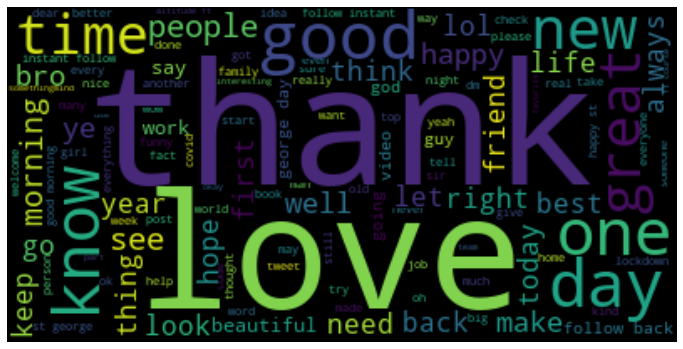

In [210]:
full_text = ''
text = df.loc[df['SENTIMENT'] == 'positive', 'TOKEN'].apply(lambda r: ' '.join(str(x) for x in r))
for t in text:
    full_text = full_text + t + '\n'
full_text

wc = WordCloud().generate(full_text)

plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

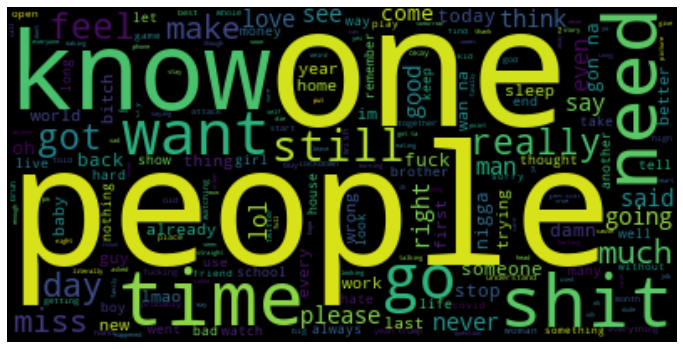

In [211]:
full_text = ''
text = df.loc[df['SENTIMENT'] == 'negative', 'TOKEN'].apply(lambda r: ' '.join(str(x) for x in r))
for t in text:
    full_text = full_text + t + '\n'
full_text

wc = WordCloud().generate(full_text)

plt.figure(figsize=(12,12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show